In [1]:
using Gridap, Gridap.Geometry, Gridap.Fields
using Gmsh, GridapGmsh
using GLMakie, DelimitedFiles, Interpolations
using LinearAlgebra, SparseArrays, KrylovKit
using ChainRulesCore, Zygote
using PartitionedArrays
using NLopt
using GridapMakie

import Gridap.CellData: Interpolable
import ChainRulesCore: rrule
import Gmsh: gmsh


main_path = "/Users/jayyao/Documents/Research/RamanInFluid/"
include(main_path*"Materials/Materials.jl")
include(main_path*"Module/Mesh_Periodic.jl")
include(main_path*"Module/Helper.jl")
include(main_path*"Module/GridapFE.jl")
include(main_path*"Module/Control.jl")
include(main_path*"Module/Model.jl")
include(main_path*"Module/Objective.jl")

g0_p_optimize (generic function with 3 methods)

In [40]:
material = "Ag"
n_λ, k_λ = RefractiveIndex(material,main_path,true)
λ1 = 532
λ2 = 549
nm1 = n_λ(λ1) + 1im * k_λ(λ1)
nm2 = n_λ(λ2) + 1im * k_λ(λ2)
nf = sqrt(1.77)
μ = 1
R = 1e-10

hr = (λ1+λ2)/nf/4          # Height of Raman molecule
# Geometry parameters of the mesh
L = 100           # Length of the normal region
hair = 500 + hr       # Height of the air region
hs = 300 + hr         # Height of the source location in air
ht = 200 + hr         # Height of the target location in air
hd = 200          # Height of design domain
hsub = 100        # Height of substrate domain below design domain
dpml = 300        # Thickness of the PML
hrd = (hd, hr)
# Characteristic length (controls the resolution, smaller the finer)
resol = 20        # Number of points per wavelength
l1 = 20      # Air
l2 = 1       # Design domain
l3 = l1           # PML

meshfile = "geometry.msh"
geo_param = PeriodicGeometry(L, hair, hs, ht, hd, hsub, dpml, l1, l2, l3)
# MeshGenerator(geo_param, meshfile)

LHp=(Inf, hair + hd)  # Start of PML for x,y > 0
LHn=(Inf, hsub)       # Start of PML for x,y < 0


ω1 = 2 * π / λ1
phys1 = PhysicalParameters(ω1, nf, nm1, nm1, μ, R, dpml, LHp, LHn, hd)
ω2 = 2 * π / λ2
phys2 = PhysicalParameters(ω2, nf, nm2, nm2, μ, R, dpml, LHp, LHn, hd)
run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`)

Process(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/geometry.msh /Users/jayyao/Documents/Research/RamanInFluid/`, ProcessExited(0))

In [42]:
############  Optimization parameters #############
flag_f = true       # Turn on filter
flag_t = true       # Turn on threshold

# Filter and threshold paramters
r = (5, 5)  # Filter radius
β = 32.0                  # β∈[1,∞], threshold sharpness
η = 0.5                   # η∈[0,1], threshold center

α = 1.0 / (2 * 1000.0)    # Equivalent loss α = 1/2Q

# Number of subspace
K = 20

# Amplify g for NLopt
Amp = 1

# Sum over kx
nkx = 30
nparts = nkx / 2

Bp = true          # Matrix B depend on parameters?
pv = 1

# Foundary constraint parameters
c = 0#resol^4
lw = r[1]
ls = r[1]
ηe = fηe(lw / r[1])
ηd = fηd(lw / r[1])

control = ControllingParameters(flag_f, flag_t, r, β, η, α, nparts, nkx, K, Amp, Bp, pv, c, ηe, ηd, hrd)

gridap = GridapFE(meshfile, 1, 2, ["DirichletEdges", "DirichletNodes"], ["DesignNodes", "DesignEdges"], ["Target"], ["Source"], flag_f, true)



Info    : Reading 'geometry.msh'...
Info    : 45 entities
Info    : 27084 nodes
Info    : 53734 elements
Info    : Done reading 'geometry.msh'


GridapParameters(UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), UnconstrainedFESpace(), 46460, UnstructuredGrid(), Measure(), Measure(), Measure(), Measure(), Measure(), Measure(), GenericCellField(), Int8[8, 8, 8, 8, 8, 8, 8, 8, 8, 8  …  10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 7)

In [55]:
run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/p_opt_value.txt /Users/jayyao/Documents/Research/RamanInFluid/`)

Process(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/p_opt_value.txt /Users/jayyao/Documents/Research/RamanInFluid/`, ProcessExited(0))

g0_p(p0; kb, phys1, phys2, control, gridap) / L = 126840.17074612643


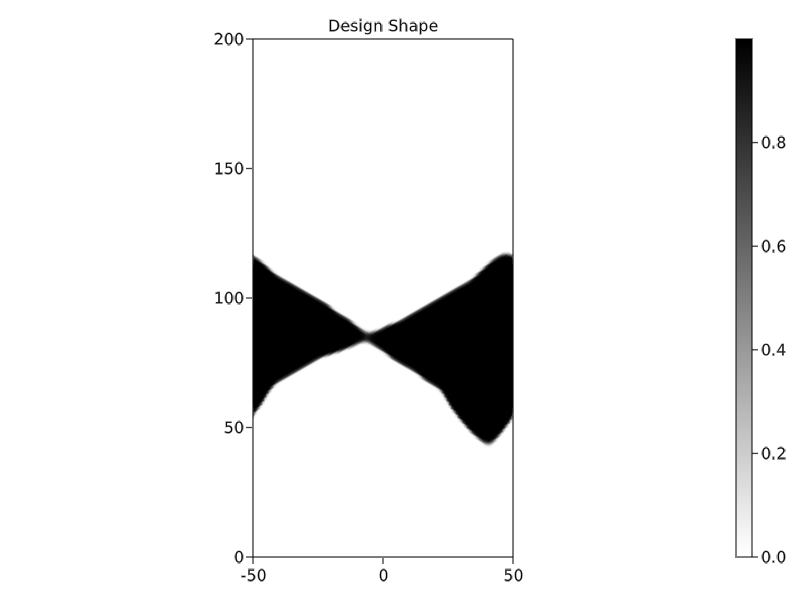

In [59]:
# Output and view
ImportFromFile = true
N = num_free_dofs(gridap.FE_U)
if ImportFromFile
    #p_max = readdlm("cloud/task5/p_opt_value.txt", Float64)
    p_max = readdlm("p_opt_value.txt", Float64)
    p0 = p_max[:]
else
    p0 = zeros(gridap.np)
end

kb = 0
pf_vec = pf_p0(p0; control, gridap)
pfh = FEFunction(gridap.FE_Pf, pf_vec)
pth = (pf -> Threshold(pf; control)) ∘ pfh
A1_mat = MatrixA(pth, kb; phys=phys1, control, gridap)
b1_vec = assemble_vector(v->(∫(v)gridap.dΓ_s), gridap.FE_V)
u1_vec = A1_mat \ b1_vec
u1h = FEFunction(gridap.FE_U, u1_vec)

A2_mat = MatrixA(pth, kb; phys=phys2, control, gridap)
o_vec = VectorO(1, 1; gridap)
v2_vec = A2_mat' \ o_vec
v2h = FEFunction(gridap.FE_U, v2_vec)

@show g0_p(p0; kb, phys1, phys2, control, gridap)/L
fig, ax, plt = plot(gridap.Ω, pth, colormap = :binary)
Colorbar(fig[1,2], plt)
ax.aspect = AxisAspect(L/(hd))
ax.title = "Design Shape"
limits!(ax, -L/2, L/2, 0, hd)
save("Results/shape.png", fig)
fig

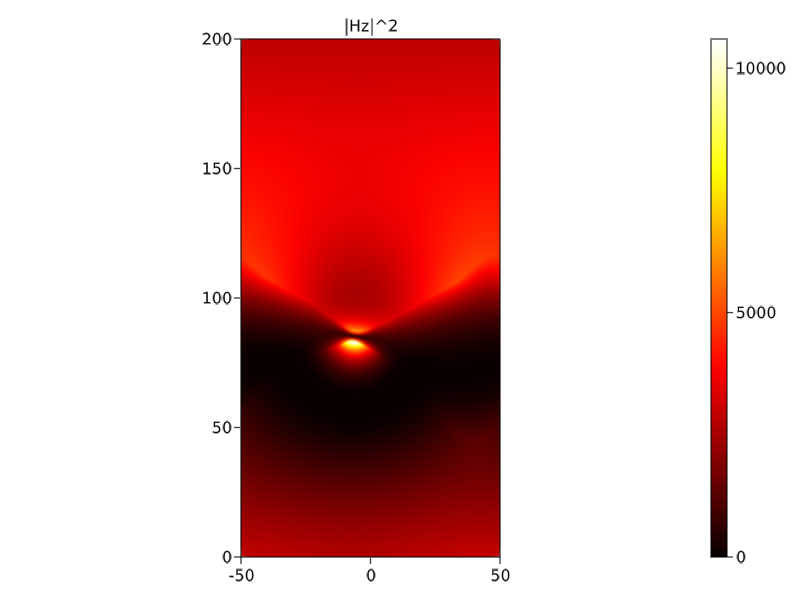

In [60]:
maxv = maximum(abs.(u1_vec))
#fig, ax, plt = plot(gridap.Ω, real(u1h), colormap = :bwr, colorrange=(-maxv, maxv))
fig, ax, plt = plot(gridap.Ω, abs2(u1h), colormap = :hot, colorrange=(0,maxv^2/1))
Colorbar(fig[1,2], plt)
ax.title = "|Hz|^2"
#ax.aspect = AxisAspect(L/(phys1.LHp[2]+phys1.LHn[2]))
#limits!(ax, -L/2, L/2, -phys1.LHn[2], phys1.LHp[2])
ax.aspect = AxisAspect(L/(hd+hr*0))
limits!(ax, -L/2, L/2, 0, hd+hr*0)
save("Results/Field.png", fig)
fig

In [58]:
run(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/g_opt_value.txt /Users/jayyao/Documents/Research/RamanInFluid/`)

Process(`scp wyao@txe1-login.mit.edu:/home/gridsan/wyao/Research/RamanInFluid/cloud/task1/g_opt_value.txt /Users/jayyao/Documents/Research/RamanInFluid/`, ProcessExited(0))